# Define parameters

In [1]:
import subprocess
import sys
import os

is_front_camera_training = False  # Change it to False if training for down cmaera.

In [10]:
################################# OS PARAMETERS ##################################
os_name = os.name
# Windows = nt, [Linux, Apple] = posix.
os_path = "\\" if os_name == "nt" else "/"
##################################################################################
############################## ROBOFLOW  PARAMETERS ##############################
roboflow_api_key = "u7zfMxAWzFvZlg4S2QTH"
roboflow_workspace_name = "robosub-2025-mu9e7"
dataset_export_format = "yolov8"
# Currently data is not labeled separately
roboflow_project_name = "douglas-vision-model"
# if is_front_camera_training:
#      roboflow_project_name = "down-camera-comp"
# else:
#      roboflow_project_name = "down-camera-sim"
##################################################################################
############################## TRAINING  PARAMETERS ##############################
# Likewise
# if is_front_camera_training:
#      target_classes = ["bouy", "gate", "octagon-table"]
#      model_save_filename = "best_AUV_sim_front_camera_model.pt"
# else:
#      target_classes = ["bin", "lane-marker", "octagon-table"]
#      model_save_filename = "best_AUV_sim_down_camera_model.pt"
# Since camera models aren't split, we train on 6 classes
# 2025 Number of class annotations (before augmentations) for those interested (delete later): 
# {"gate": 505, "octagon_table": 575, "octagon_top": 502, "path_marker": 693, "sawfish": 171, "shark": 168}
target_classes = ["gate", "octagon_table", "octagon_top", "path_marker", "sawfish", "shark"]
model_save_filename = "best_AUV_sim_model.pt"
model_name = "yolov8n"
model_name_pytorch_file=model_name + ".pt"

train_test_val_split = (0.7, 0.2, 0.1)
epoch_increments = 200
# This is likely what cause the Jetson Nano to crash
# batch_size = -1 # Auto Mode (60% GPU Memory): Use batch=-1 to automatically
#                 # adjust batch size for approximately 60% CUDA memory
#                 # utilization.
# TODO: Test setting batch size to 1 and then increment until jetson nano throws out-of-memory error. -1 scheduler works for laptops.
batch_size = 16
# TODO: Consider plotting speedup against number of processors/threads to test how many data loading threads are optimal for nano
workers = 5
cache = True
pretrained = True
hsv_h = 0.02
hsv_s = 0.3
hsv_v = 0.3
translate = 0.1
scale = 0.1
fliplr = 0.3
flipud = 0.0
mosaic = 1.0
copy_paste = 0.1
erasing = 0.1
fraction = 0.2
degrees = 25

optimizer = "AdamW"
learning_rate = 0.001 # set this to 0.01 or 0.005 for SGD
##################################################################################
######################### CUSTOM AUGMENTATION PARAMETERS #########################
colorAugmentProb = 0.5
noiseAugmentProb = 0.5
resolutionAugmentProb = 0.0
contrastAugmentProb = 0.5
blurAugmentProb = 0.5
brightnessAugmentProb = 0.5
##################################################################################

# Implementation

## Setup python dependencies

In [3]:
packages = [
     "roboflow",
     "albumentations",
     "opencv-python",
     "ultralytics",
     "pandas"
]

try:
    for package in packages:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    print("Packages installed successfully.")
except subprocess.CalledProcessError as e:
    print(f"An error occurred: {e}.")

Packages installed successfully.


In [3]:
import shutil
import cv2
import albumentations as A
import copy
import random
import numpy as np
from ultralytics import YOLO
import torch
from roboflow import Roboflow
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

/home/arthur/projects/python-venv/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
base = Path("data")
for split in ("train", "test", "val"):
    (base / "augmented" / split / "images").mkdir(parents=True, exist_ok=True)
    (base / "augmented" / split / "labels").mkdir(parents=True, exist_ok=True)

(base / "raw" / "images").mkdir(parents=True, exist_ok=True)
(base / "raw" / "labels").mkdir(parents=True, exist_ok=True)

(base / "augmented" / "images").mkdir(exist_ok=True)
(base / "augmented" / "labels").mkdir(exist_ok=True)

## Define YOLO classes

In [5]:
data_folder_absolute_path = os.path.abspath("data")
print(f"Data absolute path: {data_folder_absolute_path}.")

with open("data.yaml", "w+") as f:
    f.write(f"train: {data_folder_absolute_path}{os_path}augmented{os_path}train{os_path}images\n")
    f.write(f"test: {data_folder_absolute_path}{os_path}augmented{os_path}test{os_path}images\n")
    f.write(f"val: {data_folder_absolute_path}{os_path}augmented{os_path}val{os_path}images\n")
    f.write(f"nc: {len(target_classes)}\n")
    f.write(f"names: {target_classes}")

Data absolute path: /home/arthur/AUV-2026/ros2_ws/src/vision/model_pipeline/data.


## Define augmentation functions

In [7]:
# Given a list of samples, make two copies of each sample that are darker/brighter to simulate differently lit environments.
def brightnessAugment(images):
    out = []
    for image in images:
        transform = A.Compose([A.ColorJitter(brightness=(1.5, 1.5), contrast=0, saturation=0, hue=0, always_apply=True)])
        bright_img = transform(image=image)["image"]
        transform = A.Compose([A.ColorJitter(brightness=(0.5, 0.5), contrast=0, saturation=0, hue=0, always_apply=True)])
        dark_img = transform(image=image)["image"]
        out.append(bright_img)
        out.append(dark_img)
    return out

# Given a list of samples, make a copy of each sample but more blurred to simulate objects out of focus, dirty lenses, and backscattering.
def blurAugment(images):
    out = []
    for image in images:
        ksize = (8, 8) # lower to lower blur
        blurred_img = cv2.blur(image, ksize)
        out.append(blurred_img)
    return out

# Given a list of samples, make a copy of each sample but with a lower contrast image to simulate backscattering and over/under-exposure.
def contrastAugment(images):
    out = []
    for image in images:
        transform = A.Compose([A.ColorJitter (brightness=0, contrast=(0.5, 0.5), saturation=0, hue=0, always_apply=True)])
        decontrasted_img = transform(image=image)["image"]
        out.append(decontrasted_img)
    return out

# Given a list of samples, make a copy of each sample but with camera noise added to the image to simulate different camera feeds.
def noiseAugment(images):
    out = []
    for image in images:
        transform = A.Compose([A.ISONoise(color_shift=(0.1, 0.1), intensity=(0.5, 0.5), always_apply=True)])
        noisy_img = transform(image=image)["image"]
        out.append(noisy_img)
    return out

# Given a list of samples, make a copy of each sample but with the image downscaled (lower resolution of image) to simulate lower quality cameras/images.
def resolutionAugment(images):
    out = []
    for image in images:
        transform = A.Compose([A.Downscale(scale_min=0.2, scale_max=0.2, always_apply=True)])
        low_res_img = transform(image=image)["image"]
        out.append(low_res_img)
    return out

# Increase intensity of blues in given image.
def make_bluer(img, color_shift_intensity):
    img_b, img_g, img_r = cv2.split(img) # Split by channel.
    img_b = np.uint16(img_b)
    img_b += color_shift_intensity
    np.clip(img_b, 0, 255, out=img_b)
    img_b = np.uint8(img_b)
    img = cv2.merge((img_b, img_g, img_r)) # Merge adjusted channels.
    del img_b
    del img_g
    del img_r
    return img

# Increase intensity of greens in given image.
def make_greener(img, color_shift_intensity):
    img_b, img_g, img_r = cv2.split(img) # Split by channel.
    img_g = np.uint16(img_g)
    img_g += color_shift_intensity
    np.clip(img_g, 0, 255, out=img_g)
    img_g = np.uint8(img_g)
    img = cv2.merge((img_b, img_g, img_r)) # Merge adjusted channels.
    del img_b
    del img_g
    del img_r
    return img

# Given a list of samples, make two copies of each sample (one bluer, one greener) to simulate different pools + color attenuation.
def colorAugment(images):
    out = []
    color_shift_intensity = int(255*0.05)
    for image in images:
        blue_img = make_bluer(image, color_shift_intensity)
        green_img = make_greener(image, color_shift_intensity)
        out.append(blue_img)
        out.append(green_img)
    return out

# Given a single image and augmentation function, displays the image before and images after augmentation.
def visualizeAugmentation(img, aug):
    # Show original image.
    cv2.imshow("og", img)
    cv2.waitKey(0)
    # Show all augmented images.
    for augmented in aug([(img, "")])[1:]:
        cv2.imshow("augmented", augmented[0])
        cv2.waitKey(0)

In [8]:
def get_file_names(source_folder):
    label_filenames = []
    img_filenames = [f for f in os.listdir(source_folder + f"{os_path}images") if os.path.isfile(os.path.join(source_folder + f"{os_path}images", f))]
    for img_filename in img_filenames:
        label_filenames.append(os.path.splitext(img_filename)[0] + ".txt")

    return np.array(img_filenames), np.array(label_filenames)

def split_images_left_right(source_dir, dest_dir):
    datasets = [f"{source_dir}"]

    os.makedirs(dest_dir, exist_ok=True)
    
    left_data_path = f"{dest_dir}/left"
    right_data_path = f"{dest_dir}/right"
    os.makedirs(f"{left_data_path}/images", exist_ok=True)
    os.makedirs(f"{left_data_path}/labels", exist_ok=True)
    os.makedirs(f"{right_data_path}/images", exist_ok=True)
    os.makedirs(f"{right_data_path}/labels", exist_ok=True)
    
    for dataset in datasets: # make it easy to adapt if we have train/valid/test situation
        for image_name in os.listdir(f"{dataset}/images"):
            image_name_no_extension = image_name[:-4] # discard .jpg or .png
            image_path = f"{dataset}/images/{image_name}"
            image = cv2.imread(image_path)
            height, width, channels = image.shape
            width_cutoff = width // 2
            left_image = image[:, :(width_cutoff)]
            right_image = image[:, (width_cutoff):]
    
            cv2.imwrite(f"{left_data_path}/images/{image_name_no_extension}.jpg",left_image)
            cv2.imwrite(f"{right_data_path}/images/{image_name_no_extension}.jpg", right_image)
        for label_name in os.listdir(f"{dataset}/labels"):
            label_name_no_extension = label_name[:-4] # discard .txt
            label_path = f"{dataset}/labels/{label_name}"
            
            left_path = f"{left_data_path}/labels/{label_name_no_extension}"
            right_path = f"{right_data_path}/labels/{label_name_no_extension}"
            with open(label_path, 'r') as label_file, open(f"{left_path}.txt", 'w') as left_output_file, open(f"{right_path}.txt", 'w') as right_output_file:
                for line in label_file:
                    bounding_box = line.strip().split(" ")
                    if (float(bounding_box[1]) < 0.5): # second parameter is x-center
                        x_center = 2 * float(bounding_box[1])
                        label_width = 2 * float(bounding_box[3]) # third parameter is width
                        if (x_center + label_width / 2 > 1.0):
                            label_width = 2 * (1.0 - x_center)
                        if (x_center - label_width / 2 < 0.0):
                            label_width = 2 * x_center
                        bounding_box[1] = str(x_center)
                        bounding_box[3] = str(label_width)
                        new_bb_string = " ".join(bounding_box)
                        left_output_file.write(new_bb_string + "\n")
                    else:
                        x_center = 2 * float(bounding_box[1]) - 1
                        label_width = 2 * float(bounding_box[3])
                        if (x_center + label_width / 2 > 1.0):
                            label_width = 2 * (1.0 - x_center)
                        if (x_center - label_width / 2 < 0.0):
                            label_width = 2 * x_center
                        bounding_box[1] = str(x_center)
                        bounding_box[3] = str(label_width)
                        new_bb_string = " ".join(bounding_box)
                        right_output_file.write(new_bb_string + "\n")

def split_and_move_data(source_dir, dest_dir, split_ratio=(0.7, 0.2, 0.1)):
    source_image_dir = f"{source_dir}{os_path}images"
    source_label_dir = f"{source_dir}{os_path}labels"
    # Get list of image and label files.
    image_files = sorted(os.listdir(source_image_dir))
    label_files = sorted(os.listdir(source_label_dir))

    # Shuffle the indices.
    indices = np.arange(len(image_files))
    np.random.shuffle(indices)

    # Calculate split indices.
    total_count = len(image_files)
    train_end = int(total_count * split_ratio[0])
    val_end = train_end + int(total_count * split_ratio[1])

    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]

    # Function to move files
    def move_files(indices, split):
        for i in indices:
            shutil.move(os.path.join(source_image_dir, image_files[i]),
                        os.path.join(dest_dir, split, 'images', image_files[i]))
            shutil.move(os.path.join(source_label_dir, label_files[i]),
                        os.path.join(dest_dir, split, 'labels', label_files[i]))

    # Move files to corresponding folders
    move_files(train_indices, 'train')
    move_files(val_indices, 'val')
    move_files(test_indices, 'test')

def get_augs(img_filename, source_folder):
    img = cv2.imread(source_folder + f"{os_path}images{os_path}" + img_filename)
    augs = [img]
    if(np.random.rand() < colorAugmentProb):
        augs = augs + colorAugment(augs)
    if(np.random.rand() < noiseAugmentProb):
        augs = augs + noiseAugment(augs)
    if(np.random.rand() < resolutionAugmentProb):
        augs = augs + resolutionAugment(augs)
    if(np.random.rand() < contrastAugmentProb):
        augs = augs + contrastAugment(augs)
    if(np.random.rand() < blurAugmentProb):
        augs = augs + blurAugment(augs)
    if(np.random.rand() < brightnessAugmentProb):
        augs = augs + brightnessAugment(augs)
    return augs

def do_augs_and_export(img_filenames, label_filenames, source_folder, output_folder):
    name_num = 1
    for (img_filename, label_filename) in zip(img_filenames, label_filenames):
        augs = get_augs(img_filename, source_folder)
        with open(source_folder + f"{os_path}labels{os_path}" + label_filename) as f:
            #build array of bounding boxes (each line its own element)
            bounding_boxes = f.read()
        for aug in augs:
            cv2.imwrite(output_folder + f"{os_path}images{os_path}img" + str(name_num) + ".png", aug)
            with open(output_folder + f"{os_path}labels{os_path}img" + str(name_num) + ".txt", "w+") as f:
                f.write(bounding_boxes)
            name_num+=1

## Download dataset from Roboflow

In [17]:
rf = Roboflow(api_key=roboflow_api_key)
project = rf.workspace(roboflow_workspace_name).project(roboflow_project_name)
latest_version = int(project.versions()[0].version)
version = project.version(latest_version)
print("Version: " + str(version))
dataset = version.download(dataset_export_format)

loading Roboflow workspace...
loading Roboflow project...
Version: {
  "name": "Douglas Vision Model",
  "type": "object-detection",
  "version": "12",
  "augmentation": {},
  "created": 1762632358.475,
  "preprocessing": {
    "auto-orient": true,
    "contrast": {
      "type": "Adaptive Equalization"
    }
  },
  "splits": {
    "valid": 60,
    "test": 30,
    "train": 387
  },
  "workspace": "robosub-2025-mu9e7"
}



Extracting Dataset Version Zip to Douglas-Vision-Model-12 in yolov8:: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 966/966 [00:00<00:00, 4865.01it/s]


In [18]:
project_name_with_caps = "-".join(word.capitalize() for word in roboflow_project_name.split("-"))
folder_name = "{}-{}".format(project_name_with_caps, latest_version)
roboflow_folder_path = os.path.abspath(folder_name)
data_folder_path = os.path.abspath("data")

print(f"Roboflow folder name: {folder_name}.")

def copy_all_files(source, destination):
     try:
          # Ensure destination folder exists.
          os.makedirs(destination, exist_ok=True)
          # Copy all files from source to destination.
          for filename in os.listdir(source):
               source_file = os.path.join(source, filename)
               if os.path.isfile(source_file):
                    destination_file = os.path.join(destination, filename)
                    shutil.move(source_file, destination_file)
     except Exception as e:
          print(f"Error copying files: {e}.")

# Copy files from roboflow to data folder.
for folder in ["train", "valid", "test"]:
     print(f"Moving {folder} folder...")
     copy_all_files(os.path.join(roboflow_folder_path, folder, "images"),
                    os.path.join(data_folder_path, "raw", "images"))
     copy_all_files(os.path.join(roboflow_folder_path, folder, "labels"),
                    os.path.join(data_folder_path, "raw", "labels"))
     print(f"Moving {folder} folder completed.")

# Optional: Remove roboflow folder after copying files.
try:
     shutil.rmtree(folder_name)
     print(f"Removed folder: {folder_name}.")
except Exception as e:
     print(f"Error removing folder: {e}.")

Roboflow folder name: Douglas-Vision-Model-12.
Moving train folder...
Moving train folder completed.
Moving valid folder...
Moving valid folder completed.
Moving test folder...
Moving test folder completed.
Removed folder: Douglas-Vision-Model-12.


## Augment data, split into train/test/val

In [21]:
%%capture
out_folder = f"data{os_path}augmented"
split_folder = f"data{os_path}split_raw"
left_camera_folder = f"{split_folder}{os_path}left"
in_folder = f"data{os_path}raw"
train = f"{os_path}train"
val = f"{os_path}val"
test = f"{os_path}test"

#split_images_left_right(in_folder, split_folder)
raw_image_names, raw_label_names = get_file_names(left_camera_folder)
num_raw_samples = len(raw_image_names)
do_augs_and_export(raw_image_names, raw_label_names, left_camera_folder, out_folder)
split_and_move_data(out_folder, out_folder)

os.rmdir(f"data{os_path}augmented{os_path}images")
os.rmdir(f"data{os_path}augmented{os_path}labels")
shutil.rmtree(in_folder)

# Check CUDA dependencies and start training

In [6]:
if not (torch.cuda.is_available() and torch.cuda.device_count()):
    raise RuntimeError("CUDA is NOT available. Please ensure that your system has a compatible GPU and the necessary drivers are installed.")

In [7]:
runs_folder = "runs"
detect_folder = "detect"

os.makedirs(os.path.join(runs_folder, detect_folder), exist_ok=True)

In [8]:
# callback method tracks losses on the training and validation data after each fit epoch (train + val) to test model convergence and fit

# bounding box loss: This loss component measures how accurately the model predicts the spatial location and size of bounding boxes around detected objects.
# classification loss: This loss component evaluates the model's ability to correctly classify the objects within the predicted bounding boxes.
# distribution focal loss: This loss component assesses the model's robustness to class imbalances
train_box_losses, train_cls_losses, train_dfl_losses = [], [], []
val_box_losses, val_cls_losses, val_dfl_losses = [], [], []

def on_fit_epoch_end(trainer):
    # get the results.csv data
    results = pd.read_csv(trainer.csv)
    # get the current epoch number from the trainer
    current_epoch = trainer.epoch
    # save epoch's losses
    last_row = results.iloc[-1] # Gets results of latest epoch
    train_box_losses.append(last_row["train/box_loss"])
    train_cls_losses.append(last_row["train/cls_loss"])
    train_dfl_losses.append(last_row["train/dfl_loss"])
    val_box_losses.append(last_row["val/box_loss"])
    val_cls_losses.append(last_row["val/cls_loss"])
    val_dfl_losses.append(last_row["val/dfl_loss"])

    print(f"End of epoch {current_epoch + 1}")

In [12]:
data_yaml_file_absolute_path = os.path.abspath("data.yaml")

model = YOLO(model_name_pytorch_file) # load a pretrained model.

# register fit callback
model.add_callback("on_fit_epoch_end", on_fit_epoch_end)

# Start the training process.
while True:
    try:
        model.train(
            name=model_name,
            data=data_yaml_file_absolute_path,
            epochs=epoch_increments,
            batch=batch_size,
            pretrained=pretrained,
            task="detect",
            cache=cache,
            workers=workers,
            optimizer=optimizer,
            lr0=learning_rate,
            hsv_h=hsv_h,
            hsv_s=hsv_s,
            hsv_v=hsv_v,
            translate=translate,
            scale=scale,
            fliplr=fliplr,
            flipud=flipud,
            mosaic=mosaic,
            copy_paste=copy_paste,
            erasing=erasing,
            fraction=fraction,
            degrees=degrees
        )
        shutil.copyfile(f"runs{os_path}detect{os_path}train{os_path}weights{os_path}best.pt", model_save_filename)
    except RuntimeError as e:
        print(f"Caught a RuntimeError: {e}.")
        break  # Break out of the loop if an error occurs to prevent infinite loop.

SyntaxError: invalid syntax (2998388465.py, line 22)

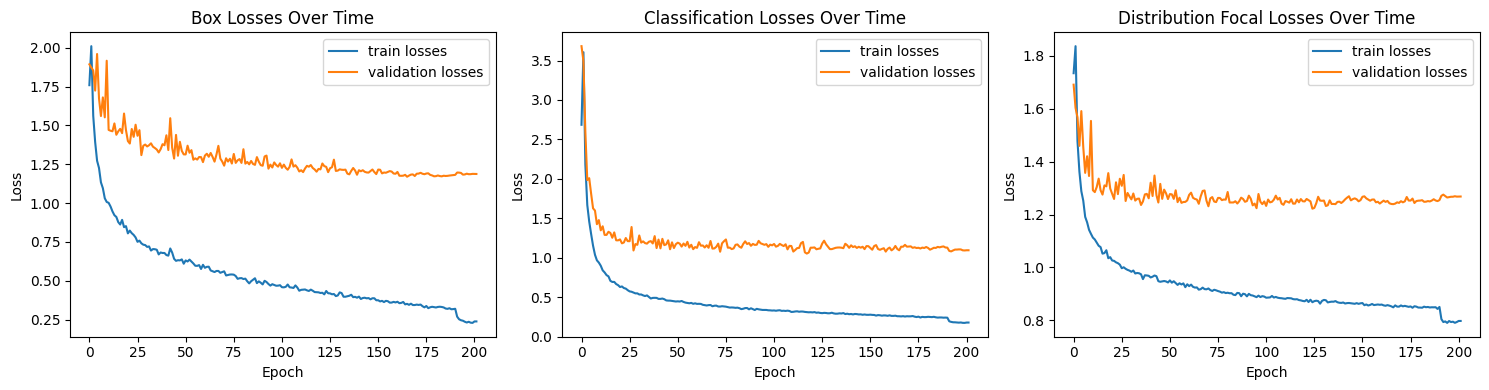

In [28]:
%matplotlib inline

fig, axes = plt.subplots(1, 3, figsize=(15, 4))  # 1 row, 3 columns

# Box losses
axes[0].plot(train_box_losses, label="train losses")
axes[0].plot(val_box_losses, label="validation losses")
axes[0].set_title("Box Losses Over Time")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()

# Classification losses
axes[1].plot(train_cls_losses, label="train losses")
axes[1].plot(val_cls_losses, label="validation losses")
axes[1].set_title("Classification Losses Over Time")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].legend()

# Distribution focal losses
axes[2].plot(train_dfl_losses, label="train losses")
axes[2].plot(val_dfl_losses, label="validation losses")
axes[2].set_title("Distribution Focal Losses Over Time")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Loss")
axes[2].legend()

plt.tight_layout()
fig.savefig("losses_over_time.png", dpi=300, bbox_inches="tight")
plt.show()

In [29]:
metrics_val = model.val(data=data_yaml_file_absolute_path, plots=True) # Save metric plots of model

Ultralytics 8.3.226 🚀 Python-3.8.20 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7806MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 504.8±248.2 MB/s, size: 361.6 KB)
val: Scanning /home/arthur/AUV-2026/ros2_ws/src/vision/model_pipeline/data/augmented/val/labels.cache... 1286 images, 132 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1286/1286 1.8Mit/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 81/81 17.8it/s 4.6s0.0s
                   all       1286       3562      0.857      0.721      0.811      0.608
                  gate        555        648      0.815      0.787      0.839      0.664
         octagon_table        646        790      0.944      0.858      0.921      0.716
           octagon_top        513        630      0.787      0.603      0.635      0.422
           path_marker        698        993      0

In [30]:
# Only run this test after finished tuning model
metrics_test = model.val(data=data_yaml_file_absolute_path, split="test", plots=True) # Save metric plots of model

Ultralytics 8.3.226 🚀 Python-3.8.20 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7806MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 628.9±108.6 MB/s, size: 428.5 KB)
val: Scanning /home/arthur/AUV-2026/ros2_ws/src/vision/model_pipeline/data/augmented/test/labels... 644 images, 80 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 644/644 1.3Kit/s 0.5s<0.1s
val: New cache created: /home/arthur/AUV-2026/ros2_ws/src/vision/model_pipeline/data/augmented/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 41/41 20.5it/s 2.0s0.0s
                   all        644       1810      0.875      0.748      0.834      0.633
                  gate        278        342      0.833      0.792      0.833      0.675
         octagon_table        340        408      0.962      0.878      0.943      0.735
           octagon_top        262        324      0.854      0.648      0.681      0.462
           path_marker  